Fake News Detection
BERT-based classification model 

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from BERT_model import to_torch, BertClassifier
from transformers import BertTokenizer, BertForSequenceClassification

In [17]:
BATCH_SIZE = 2
MODEL = BertForSequenceClassification.from_pretrained('cointegrated/rubert-tiny')
TOKENIZER =  BertTokenizer.from_pretrained('cointegrated/rubert-tiny')

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

1. Loading and preprocess data

In [18]:
train_data_path = 'dataset/train_preprocessed.csv'
test_data_path = 'dataset/test_preprocessed.csv'
# Load already preprocessed data
try:
    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)
except FileNotFoundError:
    from preprocess_data import import_data, preprocess_data
    train_df, test_df = import_data(train_data_path, test_data_path)
    train_df, test_df = preprocess_data(train_df, test_df, save=True)

test_df.head()

,title,is_fake
0,роскомнадзор представлять реестр сочетание цве...,0
1,ночь минск президентский гора беларашмор пик д...,0
2,бывший спичрайтер юрий лоза рассказывать трудн...,0
3,сельский церковь собирать рекордно низкий коли...,0
4,акция google рухнуть объявление перезапуск rutube,0


In [19]:
X = list(train_df.iloc[:, 0])
y = list(train_df.iloc[:, 1])
X_test = list(test_df.iloc[:, 0])
y_test = list(test_df.iloc[:, 1])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  random_state=11)

train = to_torch(X_train, y_train, shuffle=True, batch_size=BATCH_SIZE,
                 to_bert=True, tokenizer=TOKENIZER)
valid = to_torch(X_val, y_val, shuffle=False, batch_size=BATCH_SIZE,
                 to_bert=True, tokenizer=TOKENIZER)
test = to_torch(X_test, y_test, shuffle=False, batch_size=BATCH_SIZE,
                to_bert=True, tokenizer=TOKENIZER)

2. Setup and train BERT model

In [20]:
model = BertClassifier(MODEL, n_classes=2)

In [21]:
model.train(train, valid, lr=1e-5, n_epochs=5)

Epoch: 1/5
Validation loss: 0.655931, Accuracy: 0.796007
Epoch: 2/5
Validation loss: 0.697155, Accuracy: 0.822917
Epoch: 3/5
Validation loss: 0.715484, Accuracy: 0.830729
Epoch: 4/5
Validation loss: 0.740833, Accuracy: 0.824653
Epoch: 5/5
Validation loss: 0.757287, Accuracy: 0.828993


3. Score and visualize results

F1 metric score: 0.659


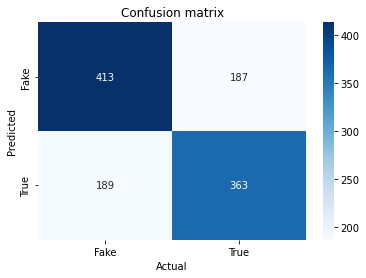

In [22]:
y_pred = model.predict(valid)

print('F1 metric score: %.3f' %f1_score(y_val, y_pred))

notation = ['Fake', 'True']
cm = pd.DataFrame(confusion_matrix(y_val, y_pred), 
                  index=notation, columns=notation)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='',
            xticklabels=notation, yticklabels=notation)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix')
plt.show()

4. Make prediction file

In [23]:
y_pred = model.predict(test)

test_df.iloc[:, 1] = y_pred
test_df.to_csv('predictions.tsv', sep='\t')